# 2.a. Earthquake location (synthetic case)

<img width=150px src="https://www.ipgp.fr/sites/default/files/ipgp_up_verticaux_rvb.png" />

## Preamble

This Jupyter notebook shows how to __locate a seismic event in space from the arrival times at several seismic station__, as part of the _Scientific Computing for Geophysical Problems_ class. It is the first part of the earthquake localization notebooks. We will do this first part together during the class, and you will solve the second part at home, from real data. You will then send your solved notebook to the email adress seydoux@ipgp.fr, as a PDF document named `lastname_firstname_2.ipynb` all lowercase.

## Requirements

This notebook relies on the four following Python libraries; please ensure that the virtual Python environment you are using includes them correctly:
- [NumPy](https://numpy.org), an open-source project aiming to enable numerical computing with Python.
- [SciPy](https://numpy.org), fundamental algorithms for scientific computing in Python.
- [Matplotlib](https://matplotlib.org), a comprehensive library for creating static, animated, and interactive visualizations in Python.

If unavailable on your machine, the following steps will guide you towards correctly installing the packages mentioned above. [Anaconda](https://www.anaconda.com) is a Python package manager that allows you to install Python libraries easily and is available from the virtual machine. If you wish to install it on your machine locally, please follow the instructions at https://www.anaconda.com. The following steps create a new environment named `scientific_computing` and install the latest version of Python 3.10 with ObsPy and Matplotlib. Note that the library NumPy is automatically installed with ObsPy. This will allow you to run this notebook properly.

Once these steps are successfully achieved, you can run the next cell to check that the installation is correct. The magic command "% matplotlitb widgets" ensures that the plots will be rendered interactively. It should appear before importing the matplotlib library.

In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d

## Dataset: P and S seismic phases arrival times

The `traveltimes/` folder contains three files `travel_times_diff_s_p_*.csv` that contain the position of the sensors towards the east ($x$) and the north ($y$) directions in kilometers, and the observed differential travel times $\tau^\text{obs}_{SP}$ in seconds at each sensor. Using pandas, we can read this data into a dataframe, as follows. 

In [12]:
# Read csv
data = pd.read_csv("./data/travel_times_diff_s_p_3.csv")

# Show table content
data

,Unnamed: 0,x,y,tt
0,0,6.334234,-1.014066,64.450715
1,1,0.681742,-5.459580,38.828154
2,2,-9.902570,-8.757286,102.360757
3,3,8.046658,8.109942,108.671816
4,4,-6.359281,9.015526,108.512106
5,5,6.606948,-1.673939,67.541356
6,6,4.912624,-0.545735,56.005124
7,7,6.807228,-8.607248,91.606640
8,8,-2.598085,-7.177902,51.271814
9,9,-0.014122,9.313582,84.985349


Thanks to the way Pandas handle the data into DataFrames, we can easily explore the data and create simple plots. The next cell shows observed differential travel times $\tau^\text{obs}_{SP}$ as a function of the station position. 

> Using the `scatter` method of matplotlib, show the observed differential tranvel times $\tau^\text{obs}_{SP}$ at each station. 
> From the observation of the travel times, can you already roughly guess (vizually) the source region? 

In [13]:
# Your code goes here

## Mean-squared error source location

The misfit function is a very important stage for every inverse problem. This function helps you identifying the best solution of your problem. Depending on the misfit function, you may identify different best solutions. 

The mean squared error (MSE) is one of the most used misfit function. If allows to quantify the average diffence between observed and predicted values by delivering the spread of the actual differences (second-order moment). Given an observed set of $N$ quantities $\mathbf{y} = (y_1, \ldots, y_N)$ and corresponding predicted quantities $\hat{\bf y} = (\hat{y}_1, \ldots, \hat{y}_N)$, the mean squared error function $\text{MSE}$ defines as

$$\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$$

For most problems, we want to find the set of parameters $\theta$ that minimize the mean square error function. Indeed, the predicted quantities are usually obtained for a given set of parameters, $\hat{\mathbf{y}} = f(\theta)$ (also called model prediction). The problem therefore writes

$$\theta^* = \argmin_{\theta} \frac{1}{N} \| \mathbf{y} - \hat{\mathbf{y}}^\theta \|^2 $$

In [14]:
def model_prediction(x_test, y_test, x_station, y_station, sp_theo=10):
    distance = np.sqrt((x_station - x_test) ** 2 + (y_station - y_test) ** 2)
    tt_predicted = distance * sp_theo
    return tt_predicted

def mean_squared_error(tt_predicted, tt_observed):
    squared_error = (tt_predicted - tt_observed) ** 2
    return np.mean(squared_error)


Once the model prediction and the misfit function are defined, we can search for the best matching source in the grid. This stage is usually the most computationally expensive stage, because we need to make __loops__ and calculate many times the prediction and mean squared error. 

> How does the source position evolve with respect to the number of points in the search grid? Does it converges towards a certain position?

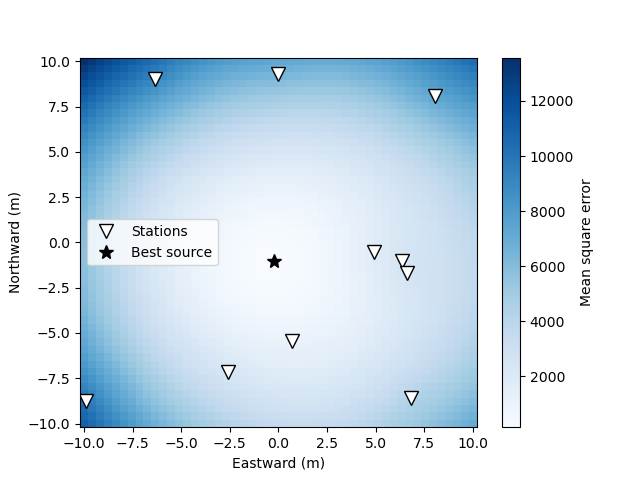

In [15]:
# Grid for searching misfit
x = y = np.linspace(-10, 10, 50)

# Initialize misfit values in the grid
mse = np.zeros((x.shape[0], x.shape[0]))

# Loop over every sources to text, and get misfit
for i in range(len(x)):
    for j in range(len(y)):
        tt_predicted = model_prediction(x[i], y[j], data.x, data.y)
        mse[i, j] = mean_squared_error(tt_predicted, data.tt)

# Extract best-matching source (from minimum misfit)
mse_min_i, mse_min_j = np.unravel_index(mse.argmin(), mse.shape)
x_best, y_best = x[mse_min_i], y[mse_min_j]

# Plot
plt.figure(3)
plt.clf()
plt.pcolormesh(x, y, mse.T, cmap="Blues")
plt.plot(data.x, data.y, "wv", mec="k", ms=10, label="Stations")
plt.plot(x_best, y_best, "k*", ms=10, label="Best source")

# Labels
colorbar = plt.colorbar()
colorbar.set_label("Mean square error")
plt.xlabel("Eastward (m)")
plt.ylabel("Northward (m)")
plt.legend()

# Show
plt.show()

## Residuals

Ahah, you thought that was it? How do you actually make sure the minimum misfit is a good estimate or a bad one? What can you use to evaluate the results quality? A powerfull tool is the analysis of the residuals. The residuals give you the indivial error at every station. It is simply defined by the element-wise error between the observed and the predicted data

$$r_i = y_i - \hat{y}_i^*$$

where $\hat{y}_i^*$ is the best matching source obtained for $\theta^*$.

> How do the residuals behave with different number of grid points? How does the theoretical travel time difference between _S_ and _P_ waves impact this result? Given the outlier analysis provided in the cell below, what would be a good strategy to locate the event better?

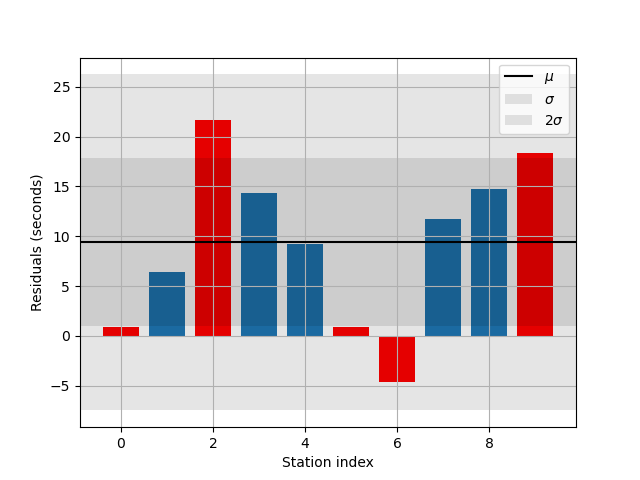

In [16]:
# Get residuals
tt_star = model_prediction(x_best, y_best, data.x, data.y)
residuals = tt_star - data.tt
r_mean = residuals.mean()
r_std = residuals.std()

# Plot
plt.figure(4)
plt.clf()

# All residuals
plt.bar(data.index, residuals)
for index, residual in enumerate(residuals):
    if (residual > (r_mean + r_std)) | (residual < (r_mean - r_std)):
        plt.bar(index, residual, fc="r")
    if (residual > (r_mean + 2 * r_std)) | (residual < (r_mean - 2 * r_std)):
        plt.bar(index, residual, fc="k")
plt.axhline(r_mean, c="k", label="$\mu$")
plt.axhspan(r_mean - r_std, r_mean + r_std, label="$\sigma$", alpha=0.1, fc="k")
plt.axhspan(r_mean - 2 * r_std, r_mean + 2 * r_std, label="$2\sigma$", alpha=0.1, fc="k")
plt.legend()
plt.xlabel("Station index")
plt.ylabel("Residuals (seconds)")
plt.grid()
plt.show()

## Question 5. Comparison with different misfit functions

As explained above, several techniques can be used to evaluate the misfit between the predicted travle times and the observed ones. We here use two new functions, named likelihood functions, that define two different approaches. 

> Check the likelihood functions defined below. What is the main difference between the two functions? 

In [17]:
def likelihood_1(tt_predicted, tt_observed, tolerance=4):
    mse = mean_squared_error(tt_predicted, tt_observed)
    return np.exp(-mse / (2 * tolerance ** 2))

def likelihood_2(tt_predicted, tt_observed, tolerance=4):
    se = (tt_predicted - tt_observed) ** 2
    return np.mean(np.exp(-se / (2 * tolerance ** 2)))

The next cell allows to identify the best matching source from the likelihood functions defined above. 

> Compared with the misfit function, what is the main change we need to do in order to find the best-matching source? How is the likelihood distribution compared with the mean squared error for the same event? From visual inspection, what is the most convenient function to estimate simultaneously the location quality and the best location?

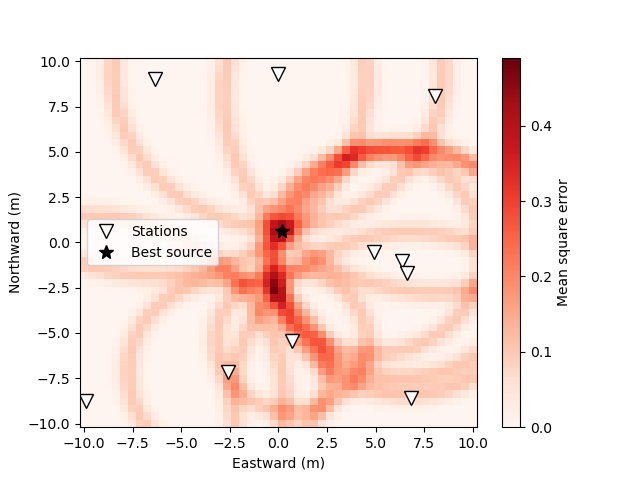

In [22]:
# Initialize misfit values in the grid
mse = np.zeros((x.shape[0], x.shape[0]))

# Loop over every sources to text, and get misfit
for i in range(len(x)):
    for j in range(len(y)):
        tt_predicted = model_prediction(x[i], y[j], data.x, data.y)
        mse[i, j] = likelihood_2(tt_predicted, data.tt)

# Extract best-matching source (from minimum misfit)
mse_min_i, mse_min_j = np.unravel_index(mse.argmax(), mse.shape)
x_best, y_best = x[mse_min_i], y[mse_min_j]

# Plot
plt.figure(5)
plt.clf()
plt.pcolormesh(x, y, mse.T, cmap="Reds")
plt.plot(data.x, data.y, "wv", mec="k", ms=10, label="Stations")
plt.plot(x_best, y_best, "k*", ms=10, label="Best source")

# Labels
colorbar = plt.colorbar()
colorbar.set_label("Mean square error")
plt.xlabel("Eastward (m)")
plt.ylabel("Northward (m)")
plt.legend()

# Show
plt.show()

> From the cells aboves, provide and estimate of the likelihood residuals. Provide comments on the quality of the likelihood compared with the mean squared error approch.
> What do you get from the other datasets?

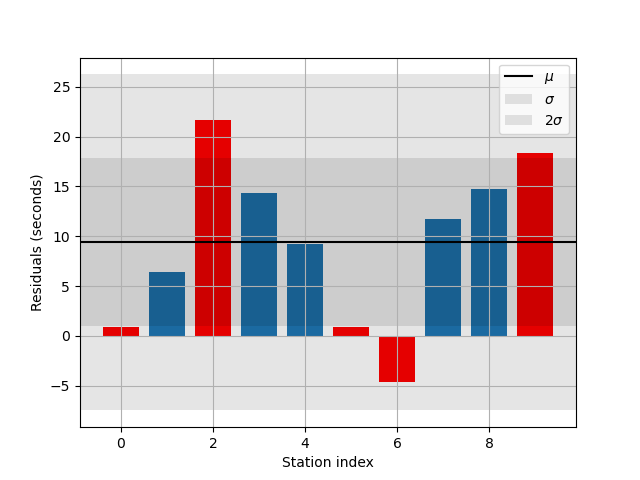

In [19]:
# Get residuals
tt_star = model_prediction(x_best, y_best, data.x, data.y)
residuals = tt_star - data.tt
r_mean = residuals.mean()
r_std = residuals.std()

# Plot
plt.figure(6)
plt.clf()

# All residuals
plt.bar(data.index, residuals)
for index, residual in enumerate(residuals):
    if (residual > (r_mean + r_std)) | (residual < (r_mean - r_std)):
        plt.bar(index, residual, fc="r")
    if (residual > (r_mean + 2 * r_std)) | (residual < (r_mean - 2 * r_std)):
        plt.bar(index, residual, fc="k")
plt.axhline(r_mean, c="k", label="$\mu$")
plt.axhspan(r_mean - r_std, r_mean + r_std, label="$\sigma$", alpha=0.1, fc="k")
plt.axhspan(r_mean - 2 * r_std, r_mean + 2 * r_std, label="$2\sigma$", alpha=0.1, fc="k")
plt.legend()
plt.xlabel("Station index")
plt.ylabel("Residuals (seconds)")
plt.grid()
plt.show()